# G&S (Jan–Sep 2026) — spline fits + normality / asymmetry diagnostics

This notebook reproduces the R workflow in Python and adds a few diagnostics to help decide:
- which spline fit's **residuals** look least normal
- whether the **South** series show stronger non-normality / over-dispersion than the **North**

**Series meaning**
- `ng` / `sg`: North / South **Groups**
- `ns` / `ss`: North / South **Sunspots**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.gofplots import qqplot
from scipy import stats

CSV_PATH = "gands_jan_sep_2026.csv"  # put this notebook in same folder as the CSV
X_COL = "JD"
Y_COLS = ["ng","sg","ns","ss"]

df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=[X_COL] + Y_COLS).copy()
df.head()


,JD,ng,sg,ns,ss,cr
0,2455928,5,3,28,8,NaN
1,2455959,3,1,9,5,NaN
2,2455988,3,3,19,11,NaN
3,2456019,3,4,16,21,NaN
4,2456049,4,5,30,17,NaN


In [2]:
# Quick descriptive stats (variance-to-mean is a simple over-dispersion check for counts)
desc = []
for col in Y_COLS:
    y = df[col].to_numpy()
    m = float(np.mean(y))
    v = float(np.var(y, ddof=1))
    desc.append({
        "series": col,
        "mean": m,
        "var": v,
        "var_over_mean": v/m if m != 0 else np.nan,
        "skew": float(stats.skew(y)),
        "kurt_excess": float(stats.kurtosis(y, fisher=True)),
    })
desc_df = pd.DataFrame(desc).sort_values("series")
desc_df


,series,mean,var,var_over_mean,skew,kurt_excess
0,ng,2.793939,3.762158,1.346543,0.181759,-0.764674
2,ns,15.412121,157.097413,10.193108,0.604236,-0.411140
1,sg,2.963636,5.986475,2.019976,0.480659,-0.637429
3,ss,18.587879,390.975462,21.033893,1.328500,1.583215


## PMF-style bar plots (empirical distributions)

These are a quick visual of over-dispersion / heavy tails.


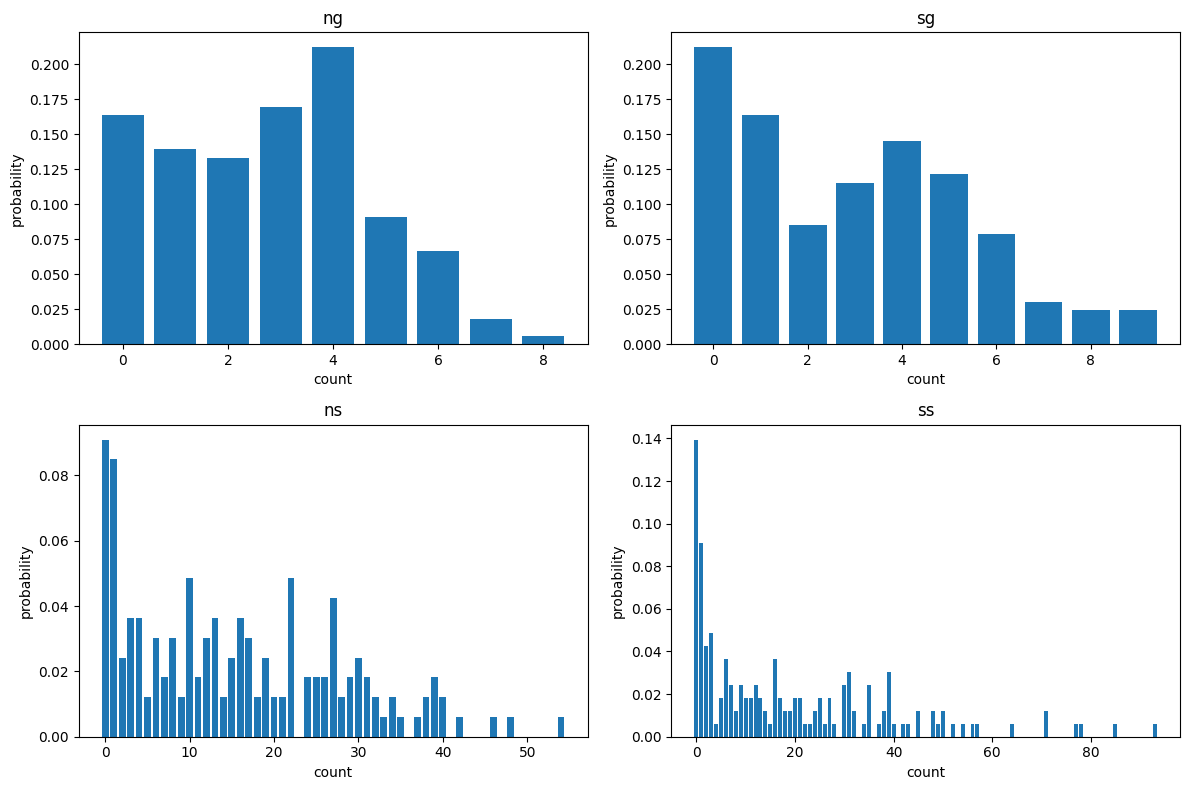

In [3]:
def pmf_plot(ax, y, title):
    vc = pd.Series(y).value_counts().sort_index()
    pmf = vc / vc.sum()
    ax.bar(pmf.index.astype(int), pmf.values)
    ax.set_title(title)
    ax.set_xlabel("count")
    ax.set_ylabel("probability")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for i, col in enumerate(Y_COLS):
    pmf_plot(axes[i], df[col], col)
plt.tight_layout()
plt.show()


## Penalized spline fits (Python analogue of `smooth.spline`)

R’s `smooth.spline(..., df=31)` is a smoothing spline with ~31 effective degrees of freedom.

In Python, a practical analogue is a **penalized B-spline GAM**:
- `df_basis` controls basis size (think "how many knots / wiggles are possible")
- `alpha` controls penalty strength (bigger = smoother)

We’ll fit two variants per series:
1. **Smooth / conservative**: `df_basis=15`, `alpha=300`
2. **More flexible** (df≈31-ish): `df_basis=31`, `alpha=100`

Then we’ll compare residual normality.


In [4]:
def fit_gam_spline(x, y, df_basis=31, degree=3, alpha=100.0):
    x = np.asarray(x)
    y = np.asarray(y)
    x2 = x[:, None]  # 2D for BSplines

    bs = BSplines(x2, df=[df_basis], degree=[degree])
    exog = np.ones((len(x), 1))  # intercept only

    model = GLMGam(y, exog=exog, smoother=bs, alpha=[alpha], family=sm.families.Gaussian())
    res = model.fit()

    fitted = res.fittedvalues
    resid = y - fitted
    return res, fitted, resid

def normality_suite(resid):
    resid = np.asarray(resid)
    resid = resid[np.isfinite(resid)]

    jb_stat, jb_p, skew, kurt = jarque_bera(resid)
    sh_stat, sh_p = stats.shapiro(resid) if len(resid) <= 5000 else (np.nan, np.nan)
    k2_stat, k2_p = stats.normaltest(resid) if len(resid) >= 8 else (np.nan, np.nan)

    return {
        "n": len(resid),
        "std": float(np.std(resid, ddof=1)),
        "skew": float(skew),
        "kurtosis_excess": float(kurt - 3.0),
        "jarque_bera_p": float(jb_p),
        "shapiro_p": float(sh_p),
        "dagostino_k2_p": float(k2_p),
    }

def plot_fit_and_resid(x, y, fit1, resid1, label1, fit2, resid2, label2, title):
    order = np.argsort(x)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title)

    ax = axes[0,0]
    ax.scatter(x, y, s=10)
    ax.plot(x[order], fit1[order], linewidth=2, label=label1)
    ax.plot(x[order], fit2[order], linewidth=2, linestyle="--", label=label2)
    ax.set_xlabel("JD")
    ax.set_ylabel("value")
    ax.legend()

    ax = axes[0,1]
    ax.scatter(fit1, resid1, s=10)
    ax.axhline(0, linewidth=1)
    ax.set_title(f"Residuals vs fitted ({label1})")
    ax.set_xlabel("fitted")
    ax.set_ylabel("residual")

    ax = axes[1,0]
    ax.scatter(fit2, resid2, s=10)
    ax.axhline(0, linewidth=1)
    ax.set_title(f"Residuals vs fitted ({label2})")
    ax.set_xlabel("fitted")
    ax.set_ylabel("residual")

    ax = axes[1,1]
    qqplot(resid2, line="45", ax=ax)
    ax.set_title(f"QQ plot residuals ({label2})")

    plt.tight_layout()
    plt.show()


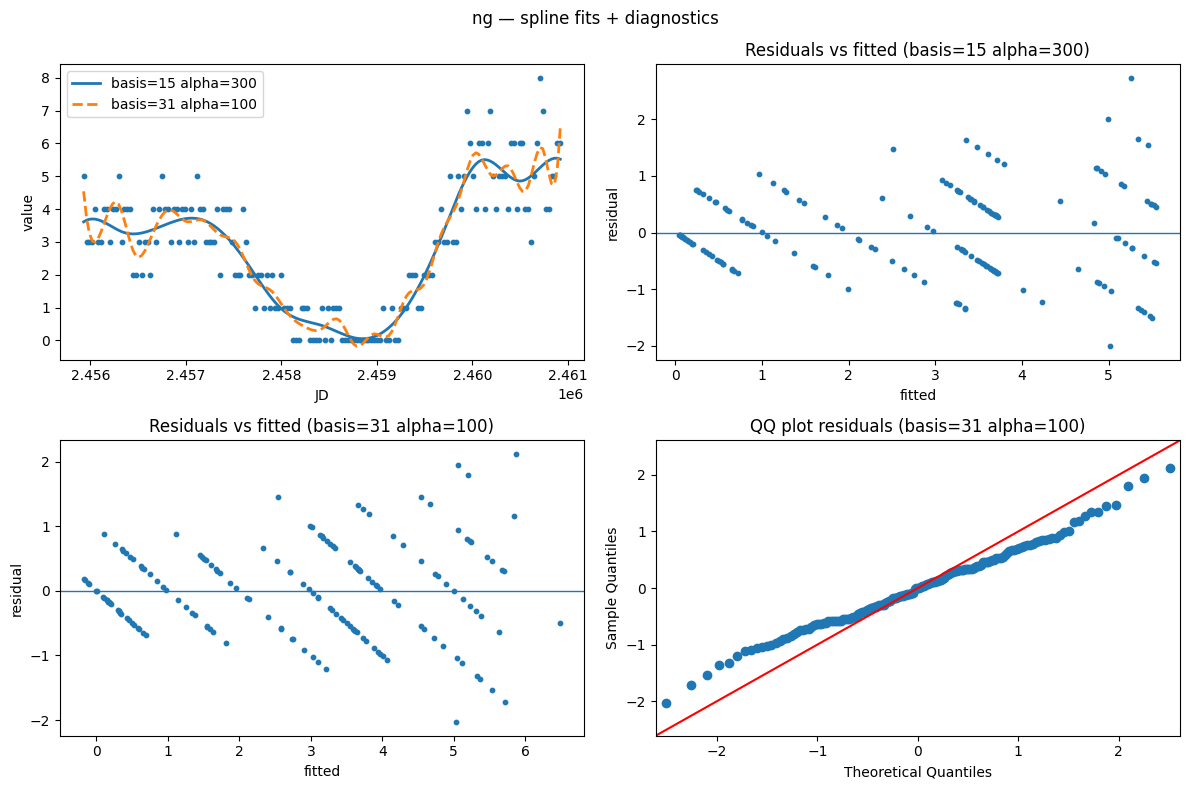

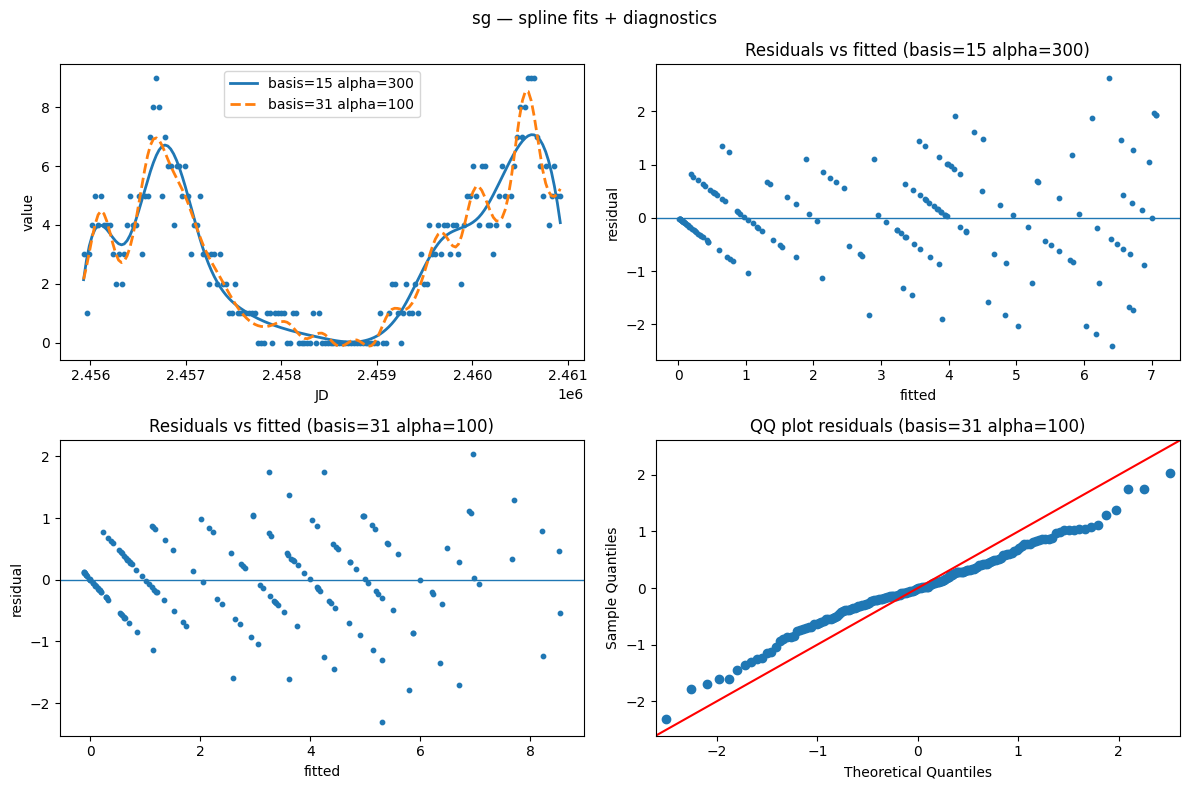

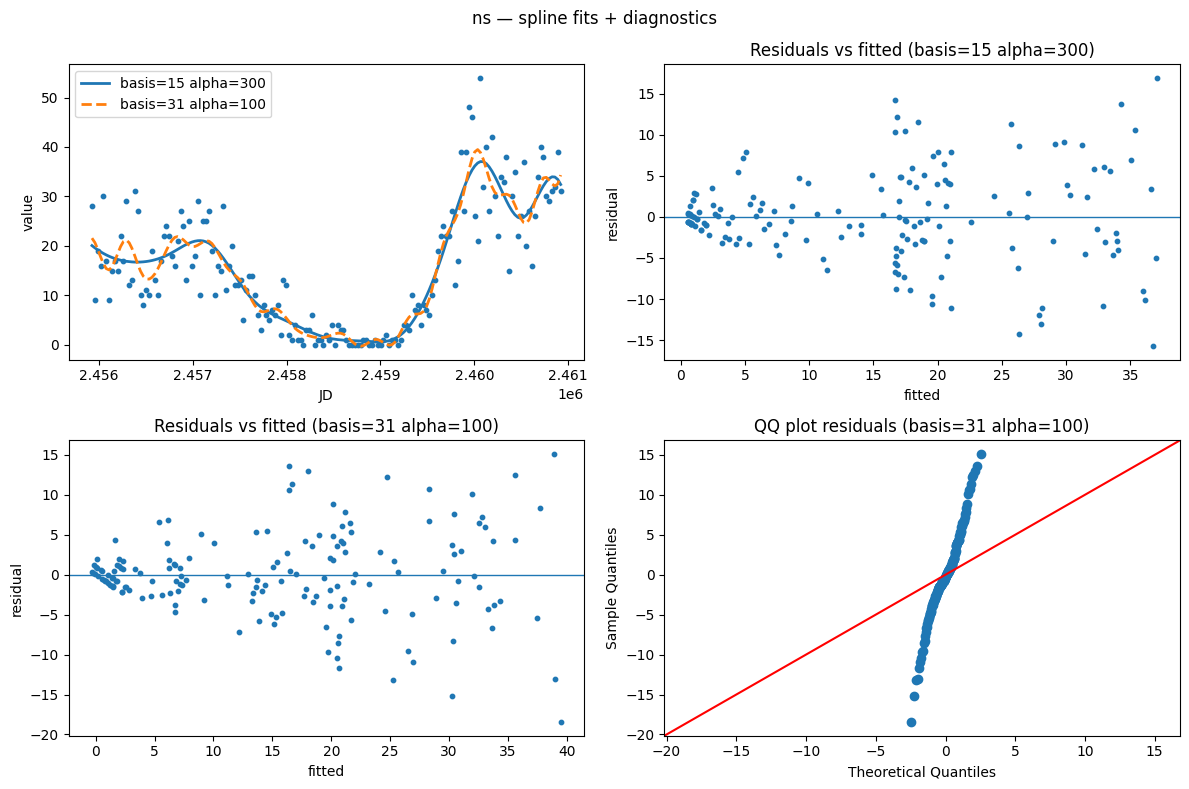

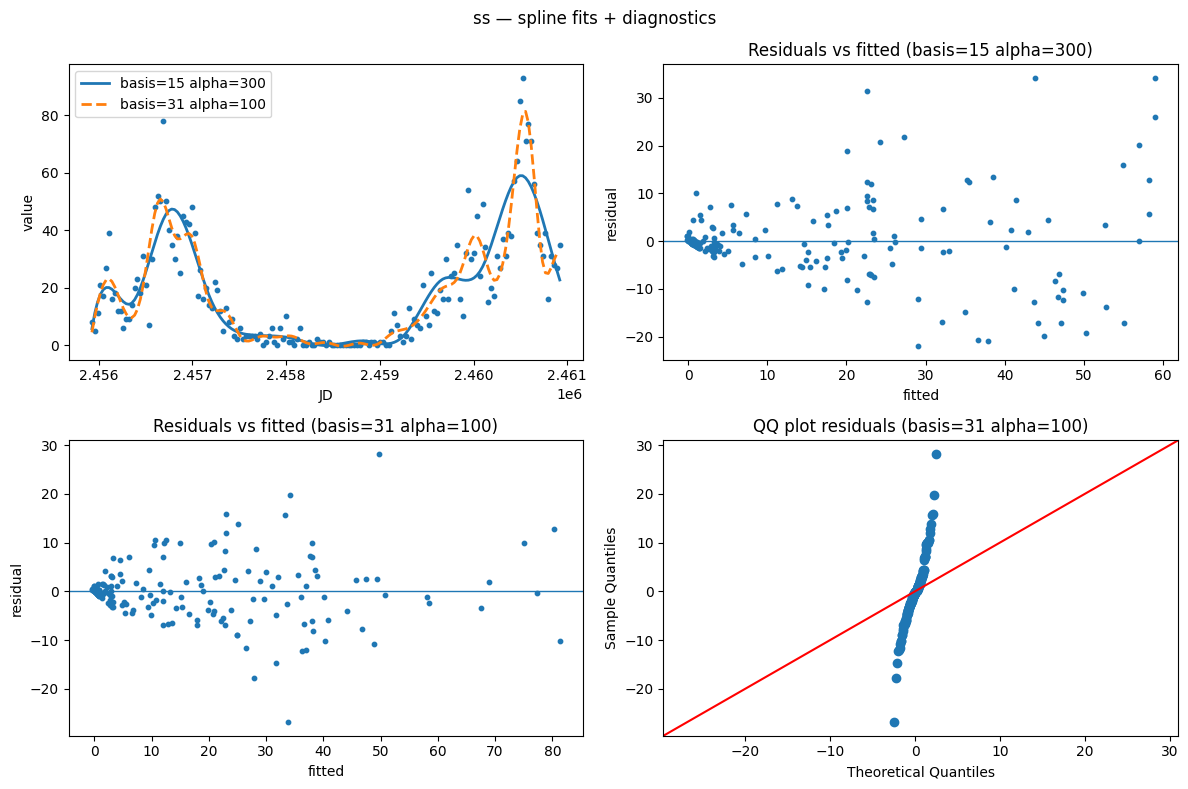

,series,fit,n,std,skew,kurtosis_excess,jarque_bera_p,shapiro_p,dagostino_k2_p
0,ss,basis=31 alpha=100,165,6.515660,0.308962,3.574029,2.292482e-20,1.179492e-06,1.387244e-05
1,ss,basis=15 alpha=300,165,9.249687,0.754299,2.601449,3.156571e-14,9.139118e-08,6.620984e-07
2,ns,basis=31 alpha=100,165,5.369432,-0.079660,1.260988,3.875065e-03,1.277770e-03,3.477798e-02
3,sg,basis=31 alpha=100,165,0.702115,-0.203621,0.713424,9.830383e-02,1.905940e-01,1.126077e-01
4,ns,basis=15 alpha=300,165,5.579497,0.098905,0.663884,1.921351e-01,2.492831e-02,2.063953e-01
5,ng,basis=15 alpha=300,165,0.771067,0.304567,0.325976,1.938370e-01,2.042792e-01,1.523719e-01
6,sg,basis=15 alpha=300,165,0.865675,-0.007336,0.665319,2.181992e-01,2.014790e-02,2.374728e-01
7,ng,basis=31 alpha=100,165,0.706023,0.170857,0.296295,4.950118e-01,7.973082e-01,4.000330e-01


In [5]:
x = df[X_COL].to_numpy()

rows = []
fits = {}

for col in Y_COLS:
    y = df[col].to_numpy()

    res_a, fit_a, resid_a = fit_gam_spline(x, y, df_basis=15, alpha=300.0)
    res_b, fit_b, resid_b = fit_gam_spline(x, y, df_basis=31, alpha=100.0)

    fits[(col, "basis=15 alpha=300")] = (fit_a, resid_a)
    fits[(col, "basis=31 alpha=100")] = (fit_b, resid_b)

    d_a = normality_suite(resid_a)
    d_b = normality_suite(resid_b)

    rows.append({"series": col, "fit": "basis=15 alpha=300", **d_a})
    rows.append({"series": col, "fit": "basis=31 alpha=100", **d_b})

    plot_fit_and_resid(
        x, y,
        fit_a, resid_a, "basis=15 alpha=300",
        fit_b, resid_b, "basis=31 alpha=100",
        title=f"{col} — spline fits + diagnostics"
    )

results = pd.DataFrame(rows)
results.sort_values(["jarque_bera_p","shapiro_p"]).reset_index(drop=True)


## “Least normal” residuals — quick ranking

Smaller p-values = stronger evidence *against* normal residuals.


In [6]:
show_cols = ["series","fit","n","std","skew","kurtosis_excess","jarque_bera_p","shapiro_p","dagostino_k2_p"]
ranked = results[show_cols].sort_values(["jarque_bera_p","shapiro_p"], ascending=True)
ranked


,series,fit,n,std,skew,kurtosis_excess,jarque_bera_p,shapiro_p,dagostino_k2_p
7,ss,basis=31 alpha=100,165,6.515660,0.308962,3.574029,2.292482e-20,1.179492e-06,1.387244e-05
6,ss,basis=15 alpha=300,165,9.249687,0.754299,2.601449,3.156571e-14,9.139118e-08,6.620984e-07
5,ns,basis=31 alpha=100,165,5.369432,-0.079660,1.260988,3.875065e-03,1.277770e-03,3.477798e-02
3,sg,basis=31 alpha=100,165,0.702115,-0.203621,0.713424,9.830383e-02,1.905940e-01,1.126077e-01
4,ns,basis=15 alpha=300,165,5.579497,0.098905,0.663884,1.921351e-01,2.492831e-02,2.063953e-01
0,ng,basis=15 alpha=300,165,0.771067,0.304567,0.325976,1.938370e-01,2.042792e-01,1.523719e-01
2,sg,basis=15 alpha=300,165,0.865675,-0.007336,0.665319,2.181992e-01,2.014790e-02,2.374728e-01
1,ng,basis=31 alpha=100,165,0.706023,0.170857,0.296295,4.950118e-01,7.973082e-01,4.000330e-01


## North vs South comparison (Groups and Sunspots)

This is a compact table of:
- variance/mean (over-dispersion)
- residual normality p-values for the more flexible spline (basis=31 alpha=100)

If South consistently shows lower p-values / higher variance-to-mean, that’s evidence of stronger non-normality / dispersion in the South series.


In [7]:
# Merge descriptive + residual diagnostics (for the more flexible fit)
desc_df = pd.DataFrame(desc)

flex = results[results["fit"]=="basis=31 alpha=100"].copy()
flex = flex[["series","jarque_bera_p","shapiro_p","dagostino_k2_p","std","skew","kurtosis_excess"]]

summary = desc_df.merge(flex, on="series", how="left")
summary = summary.sort_values("series").reset_index(drop=True)
summary


,series,mean,var,var_over_mean,skew_x,kurt_excess,jarque_bera_p,shapiro_p,dagostino_k2_p,std,skew_y,kurtosis_excess
0,ng,2.793939,3.762158,1.346543,0.181759,-0.764674,4.950118e-01,0.797308,0.400033,0.706023,0.170857,0.296295
1,ns,15.412121,157.097413,10.193108,0.604236,-0.411140,3.875065e-03,0.001278,0.034778,5.369432,-0.079660,1.260988
2,sg,2.963636,5.986475,2.019976,0.480659,-0.637429,9.830383e-02,0.190594,0.112608,0.702115,-0.203621,0.713424
3,ss,18.587879,390.975462,21.033893,1.328500,1.583215,2.292482e-20,0.000001,0.000014,6.515660,0.308962,3.574029
